In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import copy
import collections 
import scipy.stats as stats
import netgraph

with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']

MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']

def summarize_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    for d in data:        
        for result in d["reasons"]:
            if result and 'reason' in result.keys() and d['n'] == 50 and d['simulation'] == 0:
                reason_list[d['temperature']].append(result['reason'])


    for k, v in reason_list.items():    
        print(f'For temperature {k} the top 3 reasons are:')
        prompt = f"""
        # Task
        You are given a list of reasons and your task is to summarize them. You must identify the general pattern in the reasons and summarize them in a few sentences.
        You should avoid identifying specific persons.

        # Input
        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(v, indent=4)}
        </REASONS>
        """

        ans = get_response(prompt, temperature=0.9, system_prompt="You are a helpful assistant")

        print(ans)



def draw_graph(G, ax, G0=None, use_netgraph=True):
    if not G0:
        G0_edges = set()
    else:
        G0_edges = set(G0.edges())
    G_edges = set(G.edges()) - G0_edges
    if not use_netgraph:
        pos = nx.spring_layout(G)

        if not G0:
            nx.draw(G, pos, ax=ax, node_size=10, width=1.5, node_color='#d35400', alpha=0.7, edge_color='#34495e')
        else:


            nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=1.5, alpha=0.5, edge_color='#34495e', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_edges, width=1.5, alpha=1, edge_color='#e67e22', ax=ax)

            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color='#d35400', alpha=0.7, ax=ax)
    else:
        edge_color = {(u, v) : '#34495e' if (u, v) in G0_edges else '#e67e22'  for (u, v) in G.edges()}

        netgraph.Graph(G, node_layout='spring', node_color='#d35400', node_size=2.5, edge_color=edge_color, ax=ax)



    ax.set_axis_off()

def create_preferrential_attachment(T, n0, temperature):
    G = nx.erdos_renyi_graph(n0, 0.5)

    Gs = []
    results = []

    for t in range(n0, n0 + T):
        print(f'Adding node {t}')
        if t > 0:
            result = select_neighbor(G, t, temperature)
        G.add_node(t)
        
        if t > 0 and result:
            v = result['name']
            G.add_edge(t, v)

        Gs.append(G.copy())
        results.append(result)

    return Gs, results

def select_neighbor(G, t, temperature):
    degrees = []
    for v in G.nodes():
        if v != t:
            degrees.append({'name' : v, 'number_of_friends' : G.degree(v)})

    preferential_attachment_prompt = f"""
    # Task
    Your task is to select a person to be friends with.

    # Input
    The input is a list of dictionaries. Each dictionary has two keys: 'name' and 'number of friends'.
    'name' is the name of the person and 'number_of_friends' are the number of friends of the person.
    The data is given below after chevrons:
    <DEGREES>
    {json.dumps(degrees, indent=4)}
    </DEGREES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "number_of_friends" : the number of friends of the person you selected,
        "reason" : reason for selecting the person
    }}


    ```json
    """

    for i in range(10):
        try:
            result = json.loads(get_response(preferential_attachment_prompt, temperature=temperature).split('```')[0])
            if result['name'] in G.nodes():
                print('NODE DEGREES', degrees)
                print('NEW EDGE', result)
                return result
        except Exception as e:
            print(e)
        
def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures):

    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')

    print(saved_scenarios)

    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')
                    n0 = int(np.ceil(np.sqrt(n)))
                    Gs, reasons = create_preferrential_attachment(n, n0, temperature=temperature)

                    temp = {
                        'n' : n,
                        'n0' : n0,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

    f.close()

def analyze_experiments(filename):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    degree_freqs = collections.defaultdict(list)
    dergee_freqs_barabasi_albert = collections.defaultdict(list)

    wasserstein_distances = collections.defaultdict(list)

    final_graphs = collections.defaultdict(list)

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)
            G.remove_nodes_from(list(nx.isolates(G)))
            Gs.append(G)

        final_graphs[d['n'], d['temperature']].append((Gs[-1].copy(), Gs[0].copy()))

        fig, ax = plt.subplots(1, 4, figsize=(20, 5))

        # fig.suptitle(f'Graph created based on Principle 1 with $n = {d["n"]}$, $n_0 = {d["n0"]}$, temperature = {d["temperature"]}')

        fig.suptitle(f'Temperature = {d["temperature"]}')

        for i, t in enumerate([0, len(Gs) // 2, len(Gs) - 1]):
            G = Gs[t]
            ax[i].set_title(f'$t = {t}$')
            draw_graph(G, ax=ax[i], G0=Gs[0])
            
        degree_freq = nx.degree_histogram(G)
        degree_freqs[d['n'], d['temperature']].append(degree_freq)

    
        G_barabasi_albert = nx.barabasi_albert_graph(n=d['n'], m=1, initial_graph=Gs[0], seed=1)

        degree_freq_barabasi_albert = nx.degree_histogram(G_barabasi_albert)
        dergee_freqs_barabasi_albert[d['n'], d['temperature']].append(degree_freq_barabasi_albert)

        degrees = [G.degree(n) for n in G.nodes()]
        degrees_barabasi_albert = [G_barabasi_albert.degree(n) for n in G_barabasi_albert.nodes()]

        wasserstein_distances[d['n'], d['temperature']].append(stats.wasserstein_distance(degrees, degrees_barabasi_albert))

        ax[-1].set_title('Degree distribution')
        ax[-1].loglog(degree_freq,color='#d35400', marker='x', label='LLM', linewidth=2)
        ax[-1].loglog(degree_freq_barabasi_albert, color='#2980b9', marker='x', label='BA', linewidth=2) 
        ax[-1].legend()
        ax[-1].set_xlabel('Degree')
        ax[-1].set_ylabel('Frequency')

        fig.tight_layout()

        fig.savefig(f'figures/principle_1/principle_1_{d["n"]}_{d["simulation"]}_{d["temperature"]}.png', dpi=300)

    # fig, ax = plt.subplots(1, len(degree_freqs), figsize=(5 * len(degree_freqs), 5))

    # for i, k in enumerate(sorted(degree_freqs)):

    #     degree_freq = np.mean(degree_freqs[k], axis=0)
    #     degree_freq_barabasi_albert = np.mean(dergee_freqs_barabasi_albert[k], axis=0)

    #     ax[i].set_title(f'$n = {k[0]}$, temperature={k[1]}')
    #     ax[i].loglog(degree_freq, color='#16a085', marker='x', label='LLM')
    #     ax[i].loglog(degree_freq_barabasi_albert, color='#2980b9', marker='x', label='BA') 
    #     ax[i].set_xlabel('Degree')
    #     ax[i].set_ylabel('Frequency')

    # fig.tight_layout()
    # fig.savefig(f'figures/principle_1/principle_1_overall.png')

    fig, ax = plt.subplots(1, 1 + len(final_graphs), figsize=(5 * (1 + len(final_graphs)), 5), squeeze=False)
    # fig.suptitle(f'Graphs created based on Principle 1 with $n = {d["n"]}$, $n_0={d["n0"]}$')

    i = 0

    for k in sorted(final_graphs.keys()):            
        G, G0 = final_graphs[k][0]
        draw_graph(G, ax[0, i], G0=G0)
        ax[0, i].set_title(f'Temperature = {k[-1]}')
        i += 1
    
    for k in sorted(wasserstein_distances.keys()):
        mean = np.mean(wasserstein_distances[k])
        std = np.std(wasserstein_distances[k])

        ci = stats.norm.interval(0.95, loc=mean, scale=std)

        ax[0, -1].bar(k[-1], mean, yerr=std, color='#d35400', alpha=0.7, width=0.45)
        ax[0, -1].plot([k[-1], k[-1]], ci, color='#d35400', linewidth=2)

    
    ax[0, -1].set_xlabel('Temperature')
    ax[0, -1].set_ylabel('Wasserstein Distance')


    fig.tight_layout()

    fig.savefig(f'figures/principle_1/principle_1_final_graphs.png', dpi=300)

{(50, 3, 0.5), (50, 5, 0.5), (50, 9, 1.0), (50, 9, 1.5), (50, 0, 1.0), (50, 0, 1.5), (50, 2, 1.0), (50, 2, 1.5), (50, 7, 0.5), (50, 4, 1.0), (50, 4, 1.5), (50, 6, 1.0), (50, 6, 1.5), (50, 8, 1.0), (50, 8, 1.5), (50, 9, 0.5), (50, 0, 0.5), (50, 1, 1.0), (50, 1, 1.5), (50, 2, 0.5), (50, 3, 1.5), (50, 3, 1.0), (50, 4, 0.5), (50, 5, 1.5), (50, 5, 1.0), (50, 6, 0.5), (50, 8, 0.5), (50, 1, 0.5), (50, 7, 1.0), (50, 7, 1.5)}
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=1, temperature=1.0
Skipping simulation for n=50, i=1, temperature=1.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=2, temperature=1.0
Skipping simulation for n=50, i=2, temperature=1.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=3, temperature=1.0
Skipping simulatio

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_47186/530650874.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 4, figsize=(20, 5))


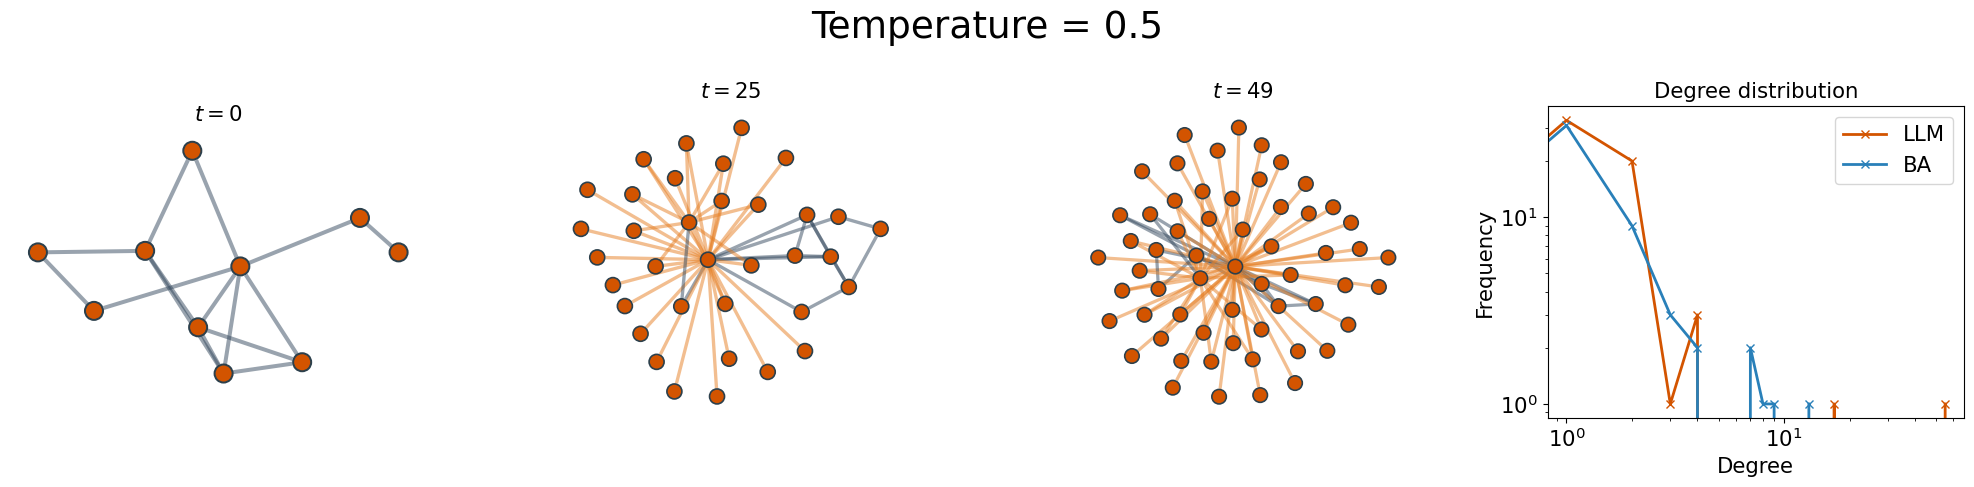

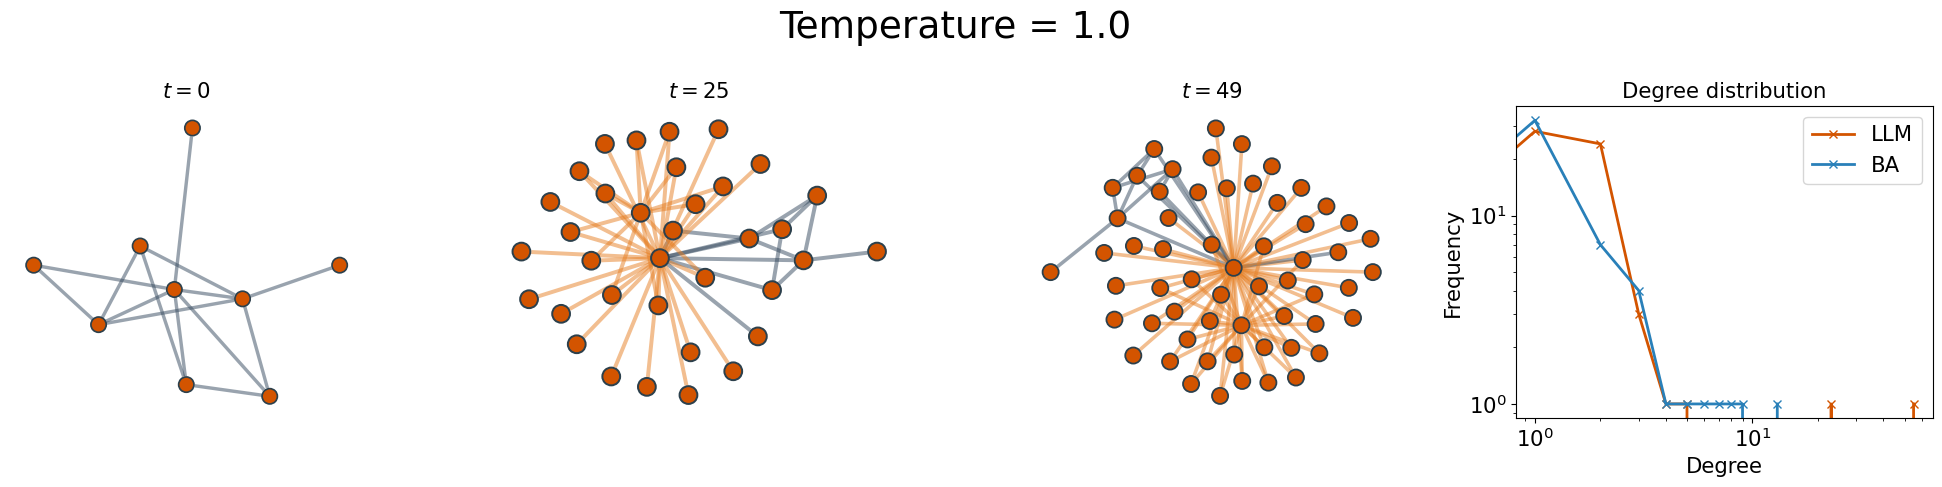

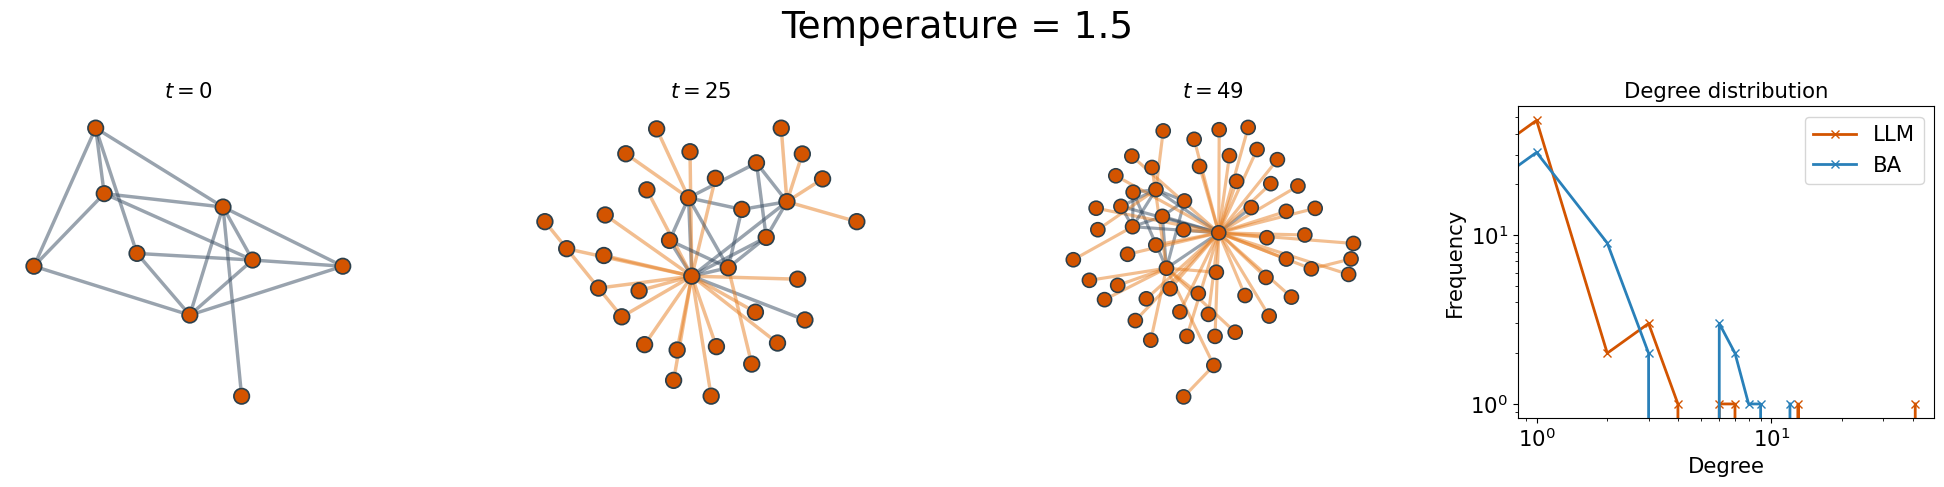

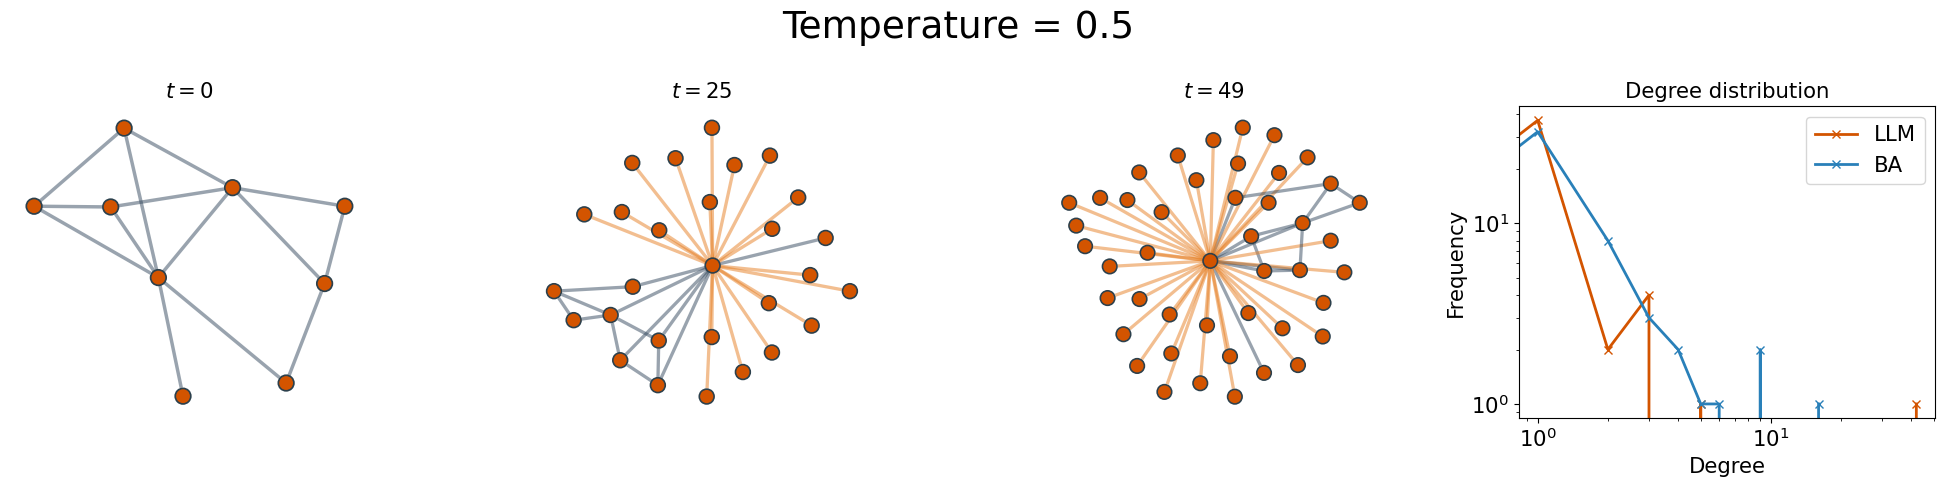

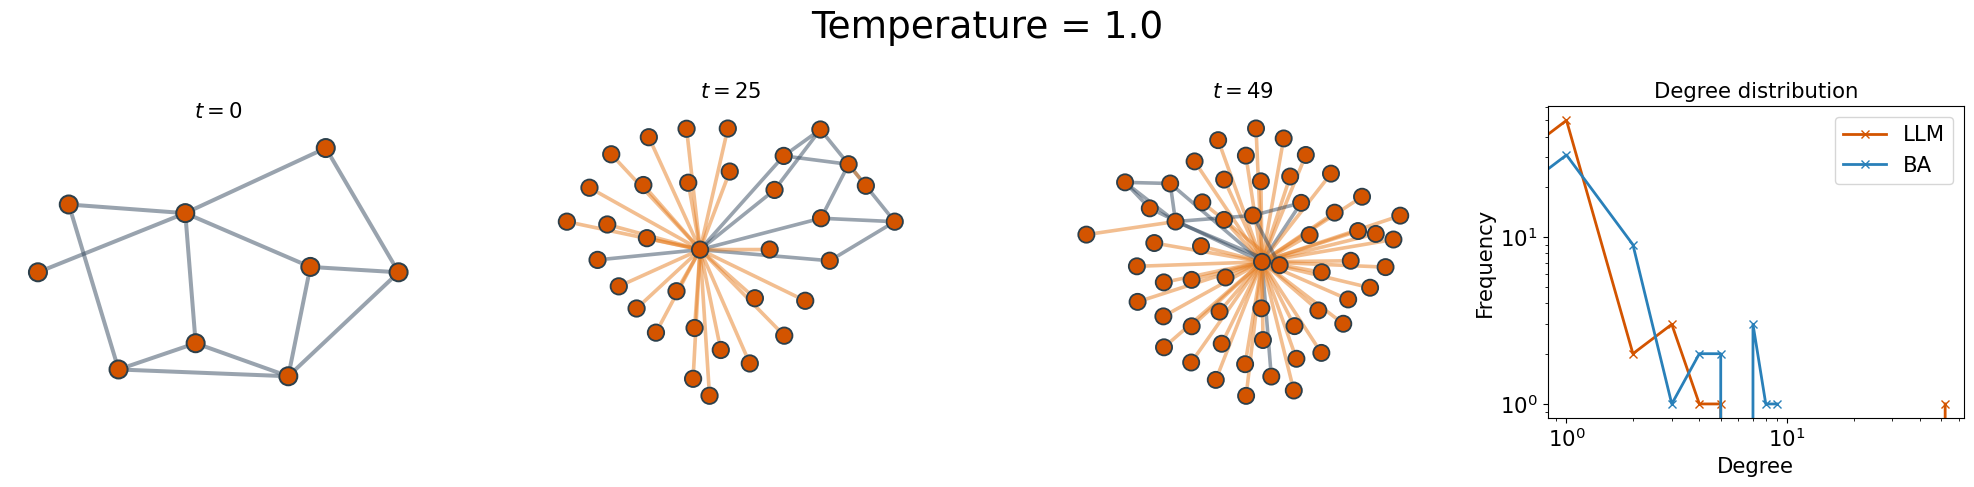

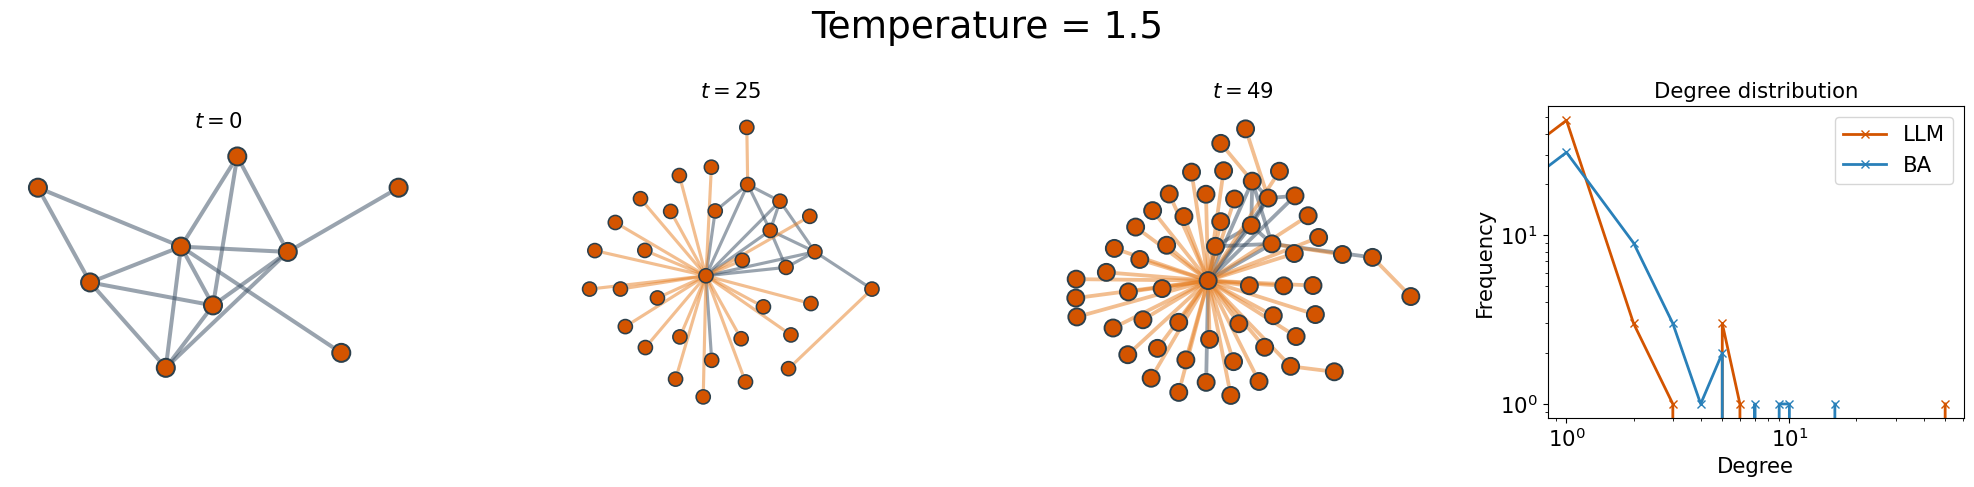

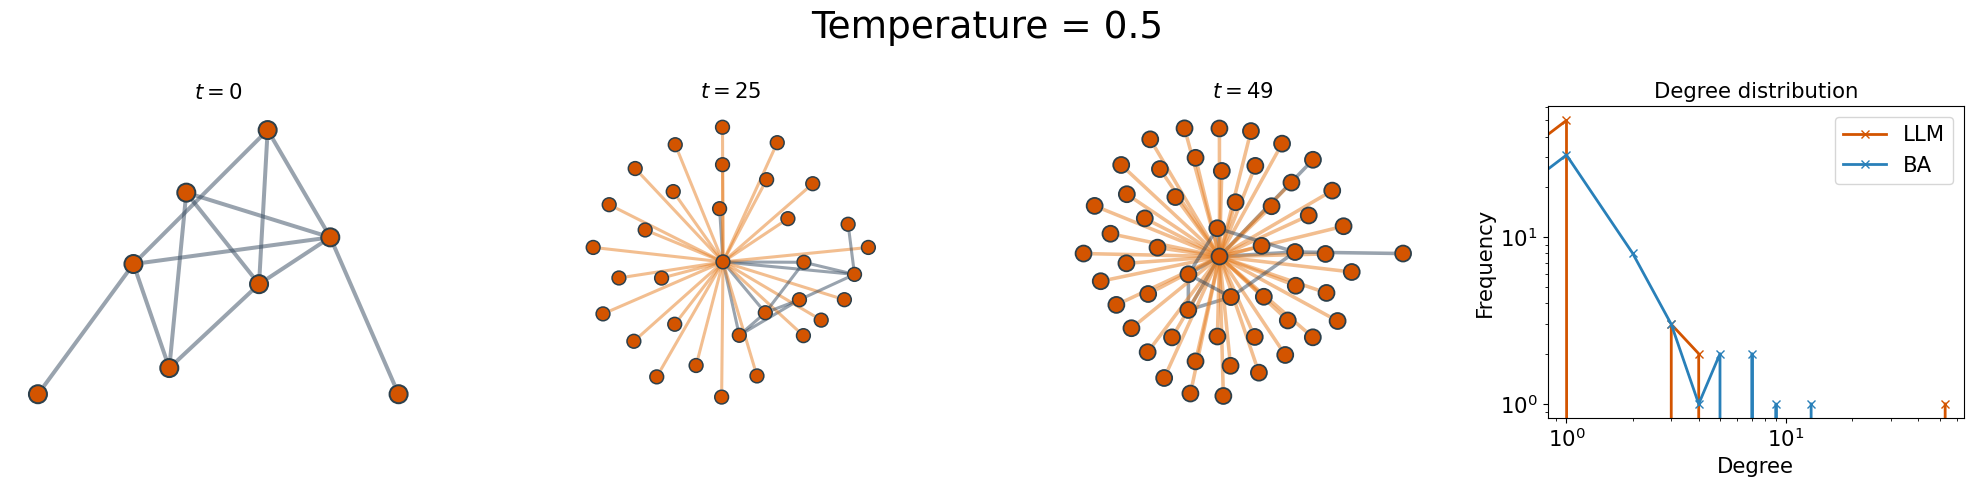

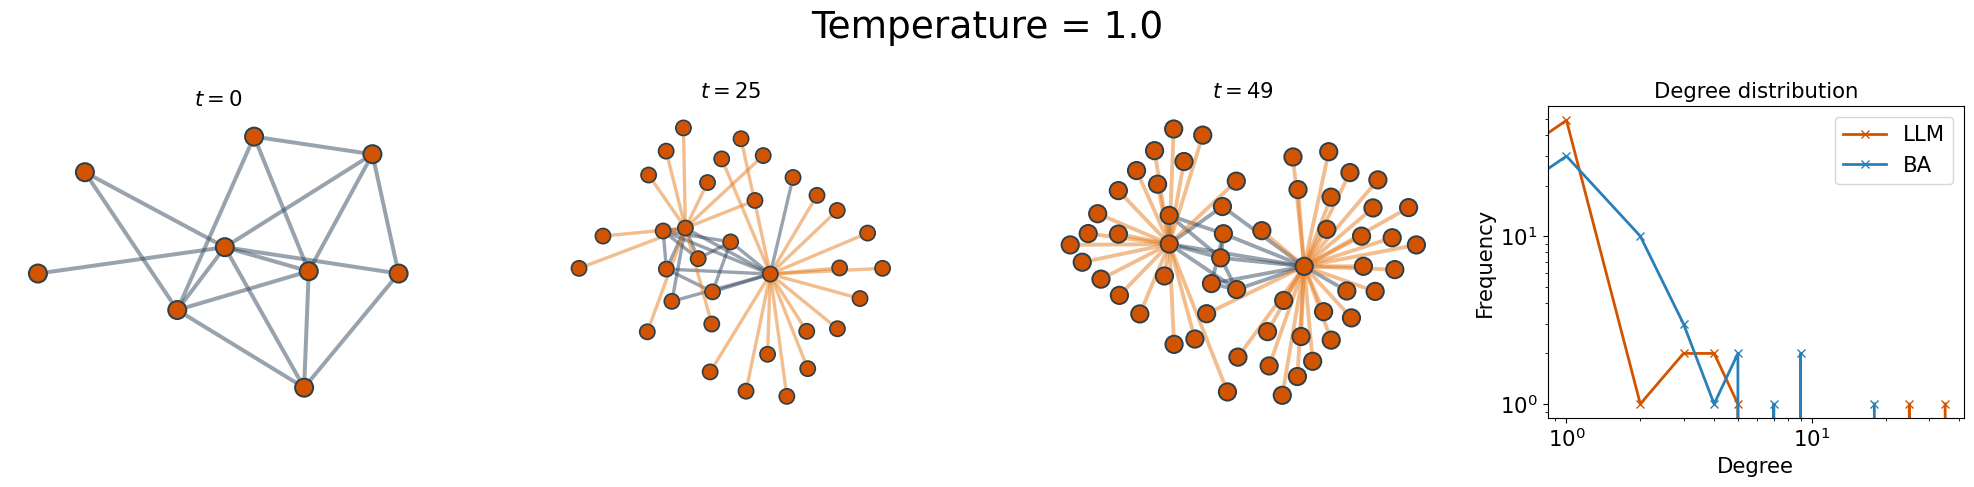

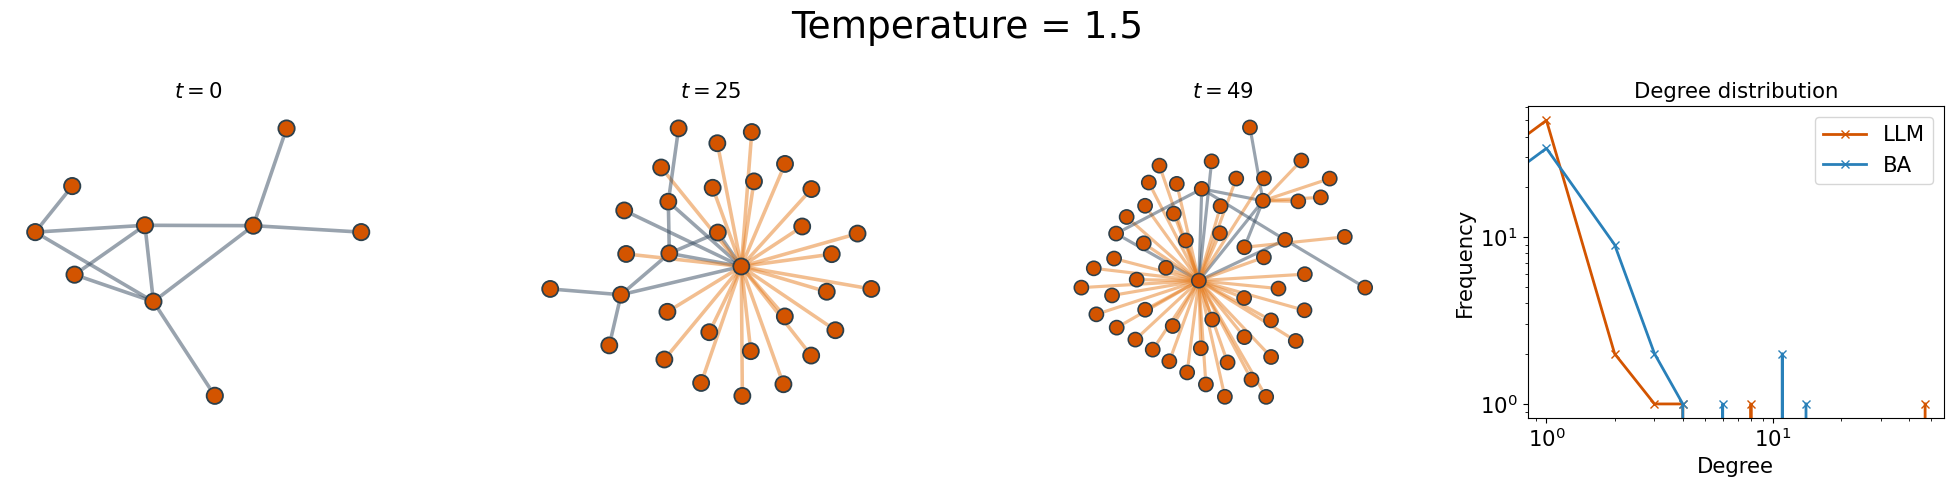

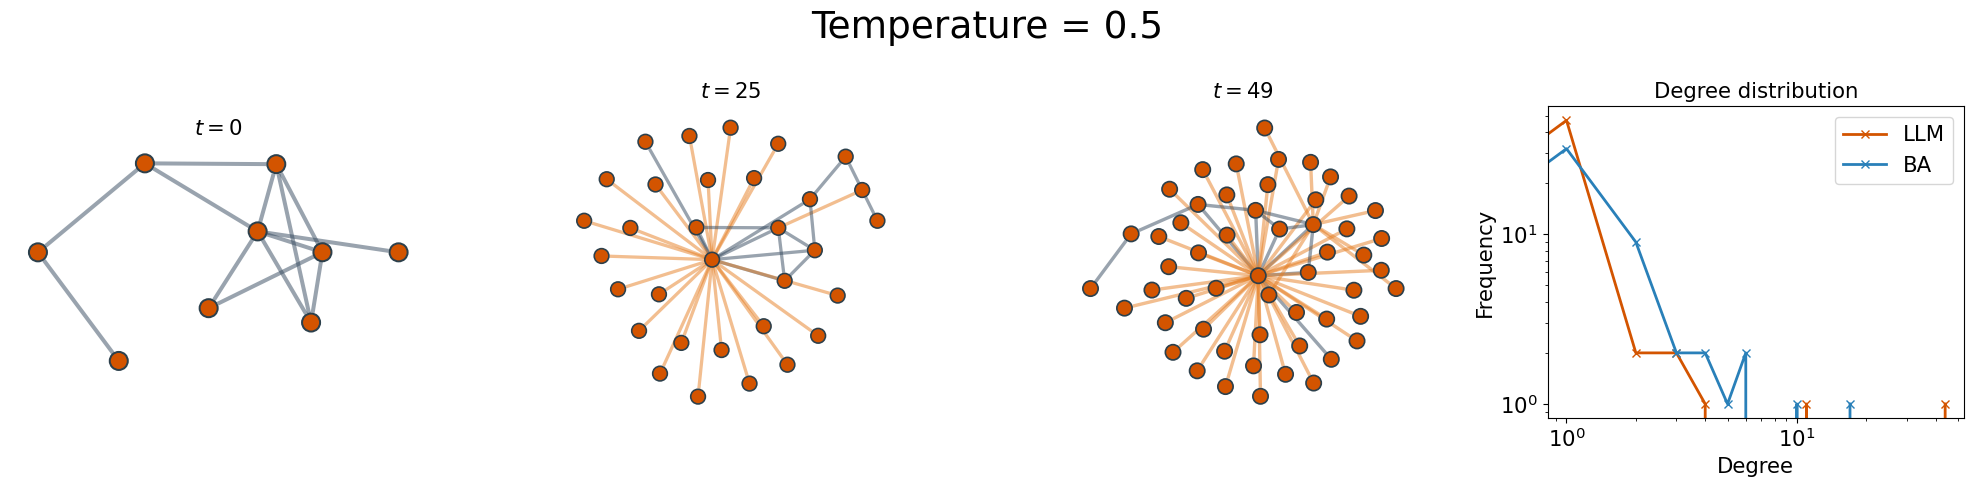

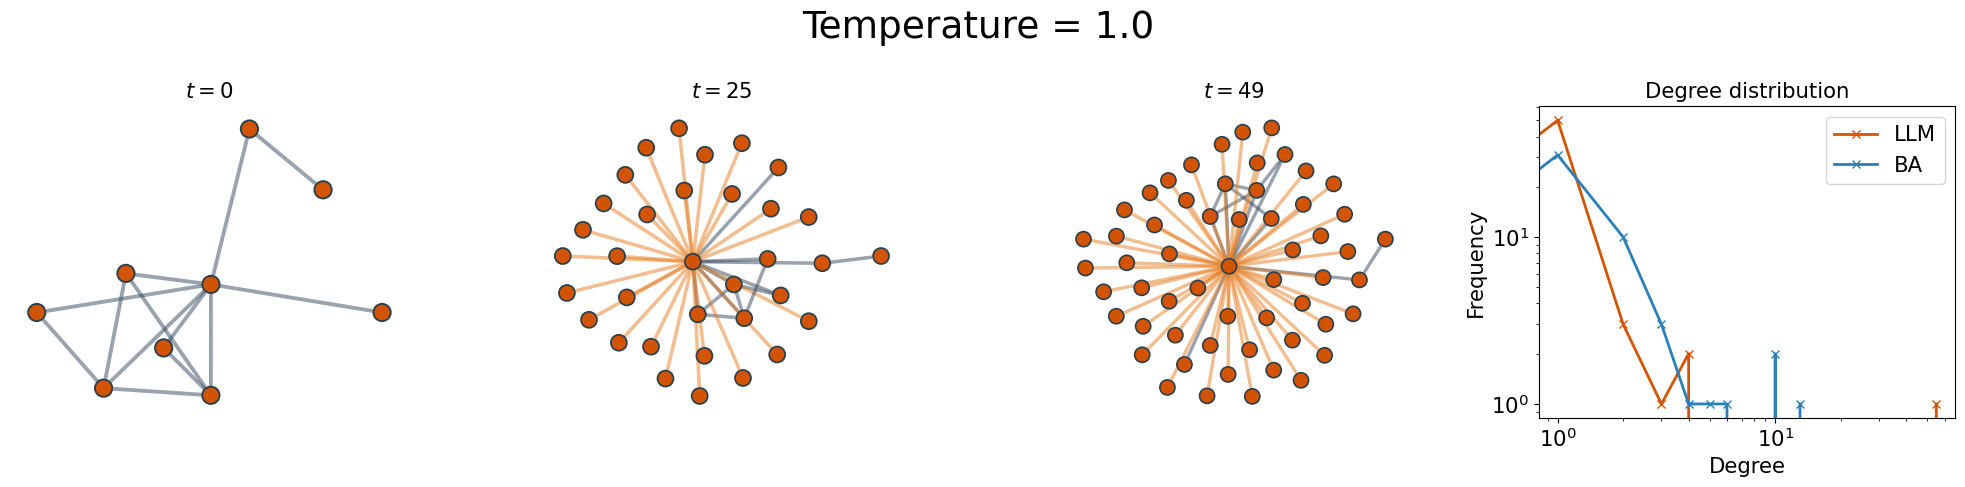

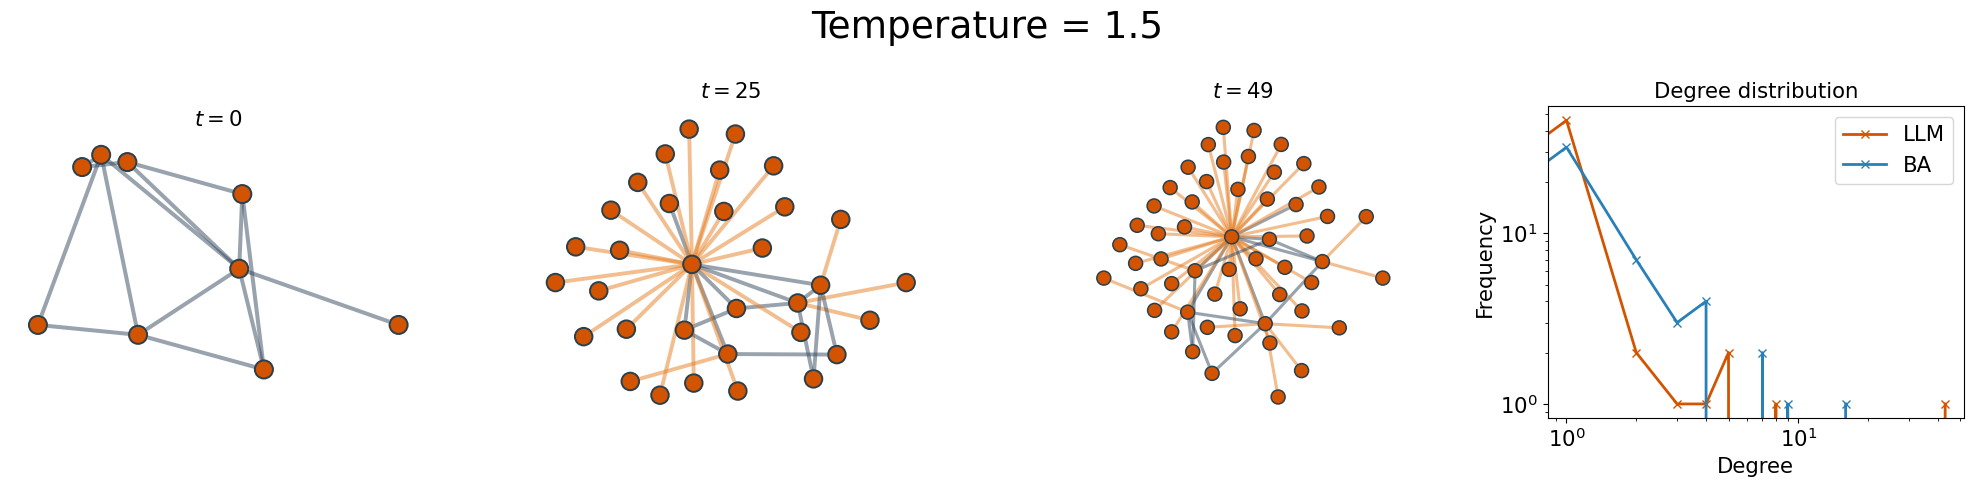

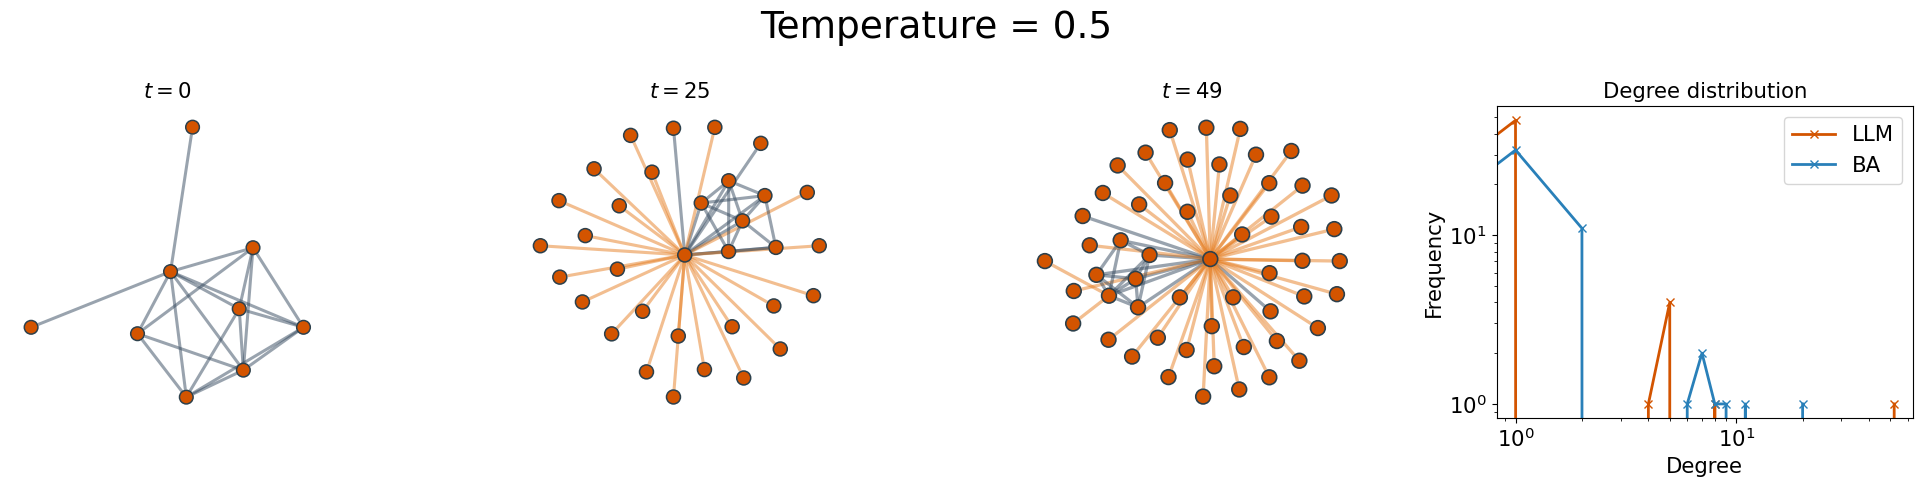

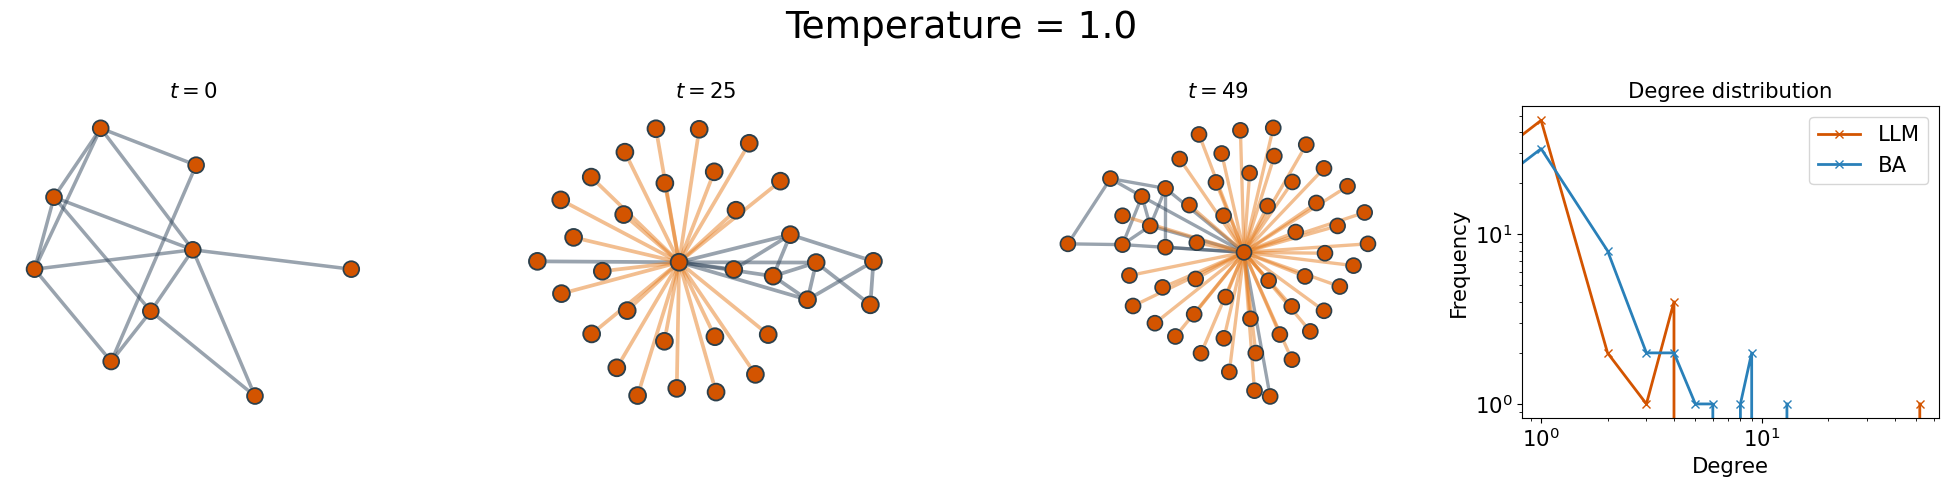

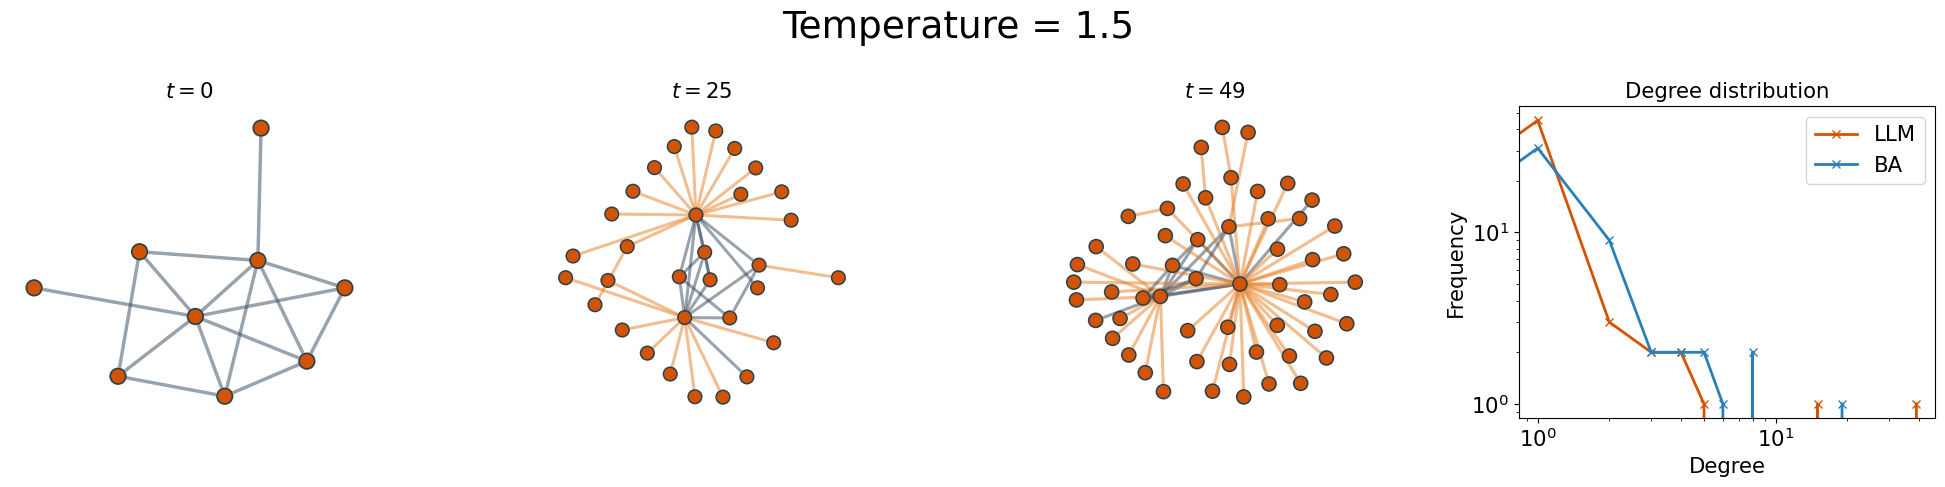

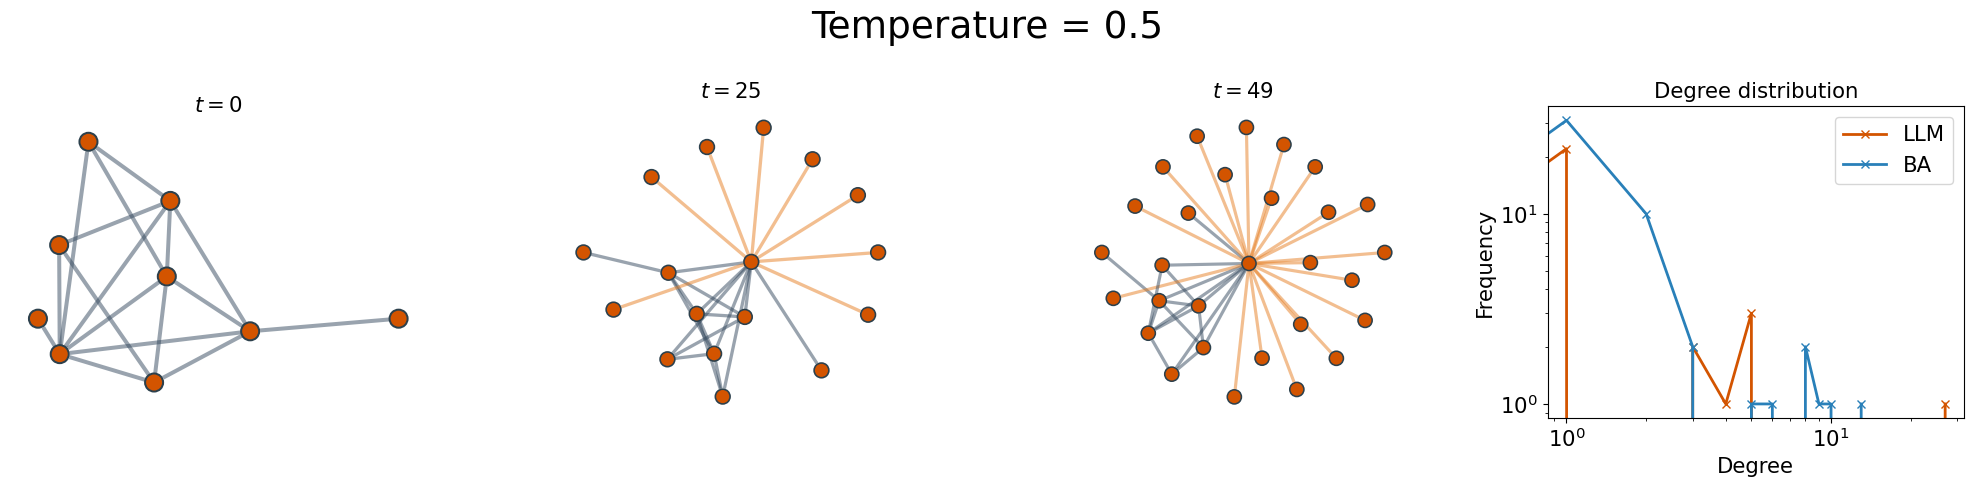

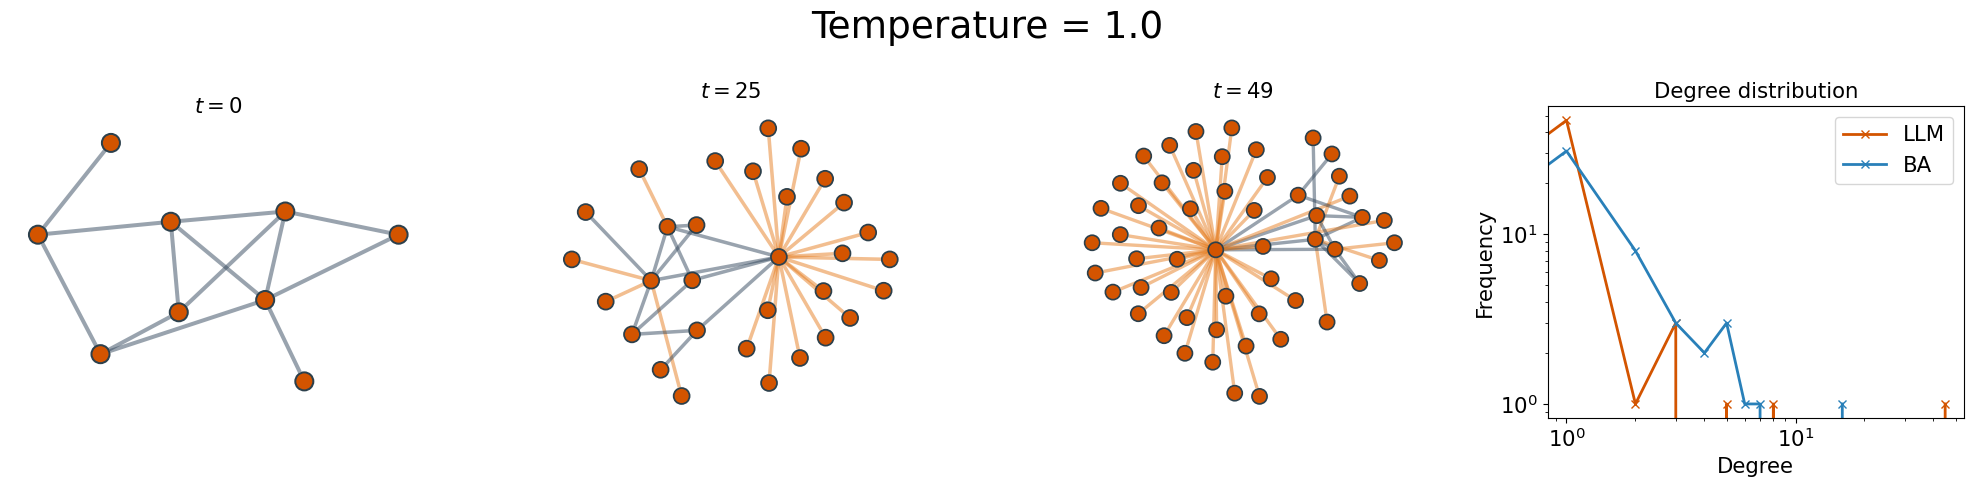

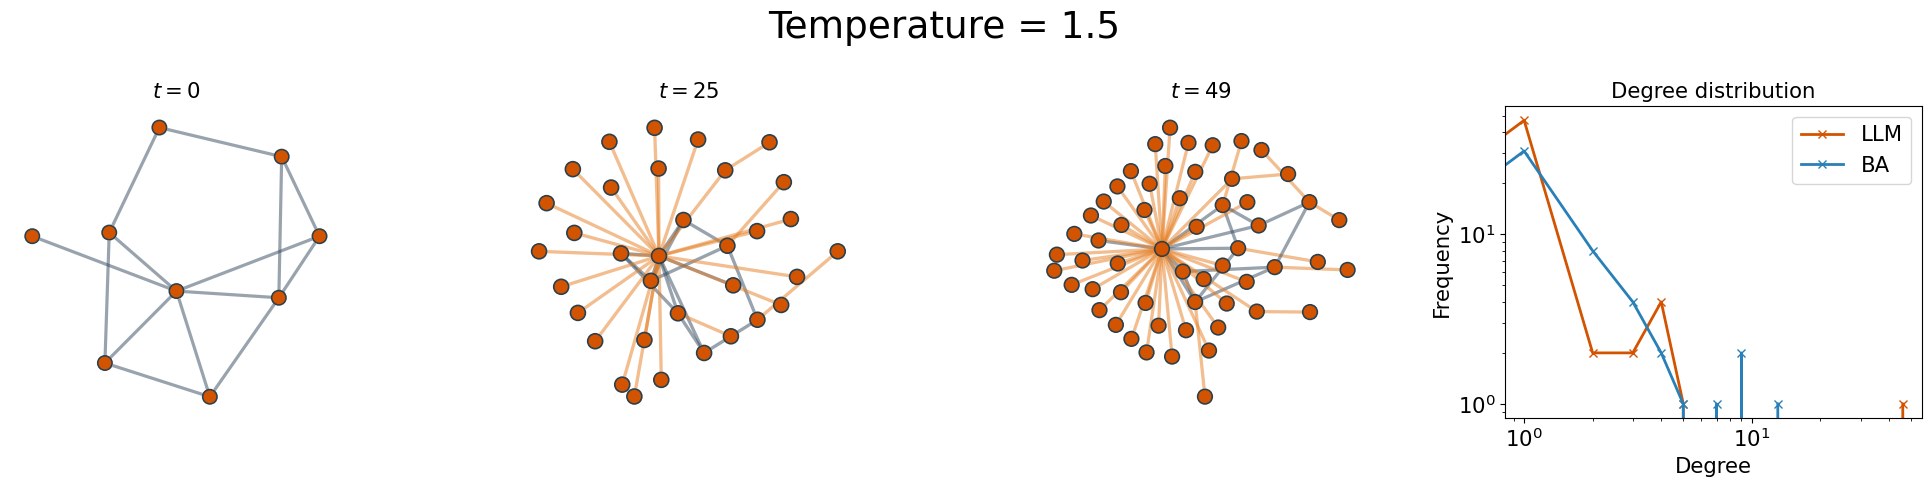

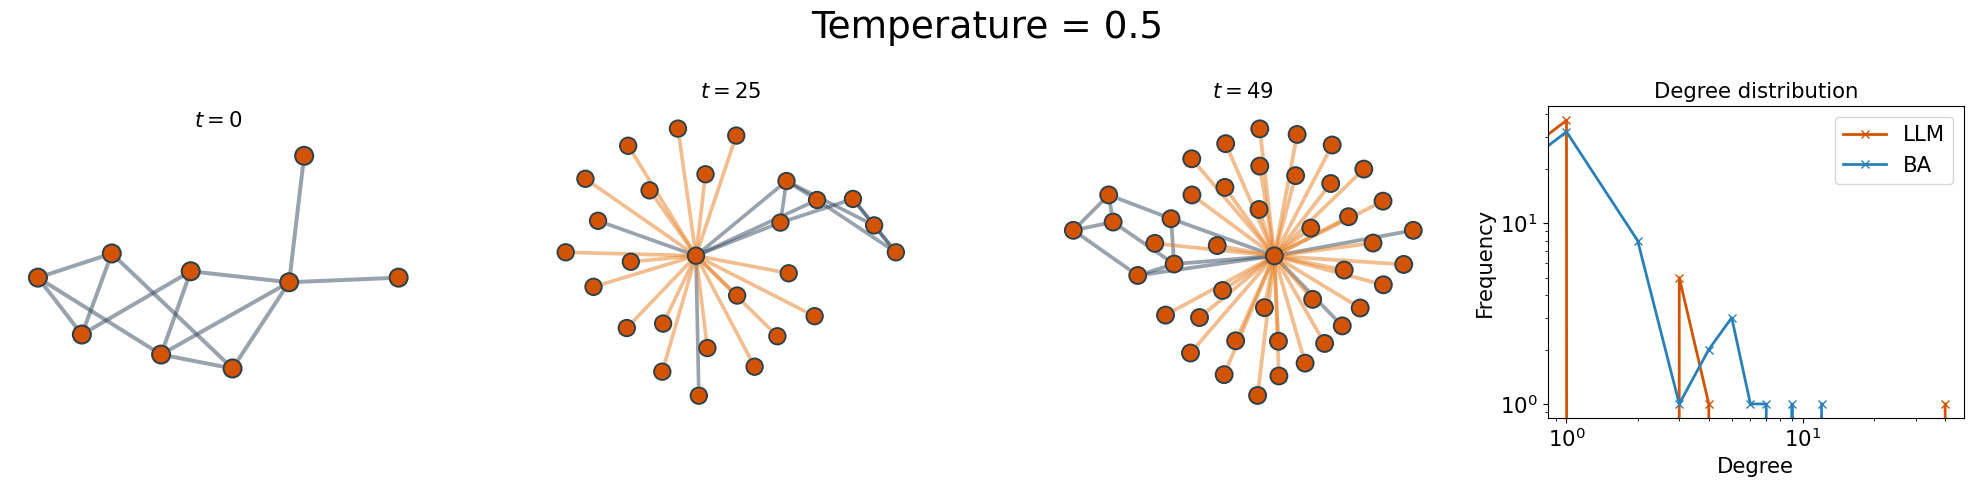

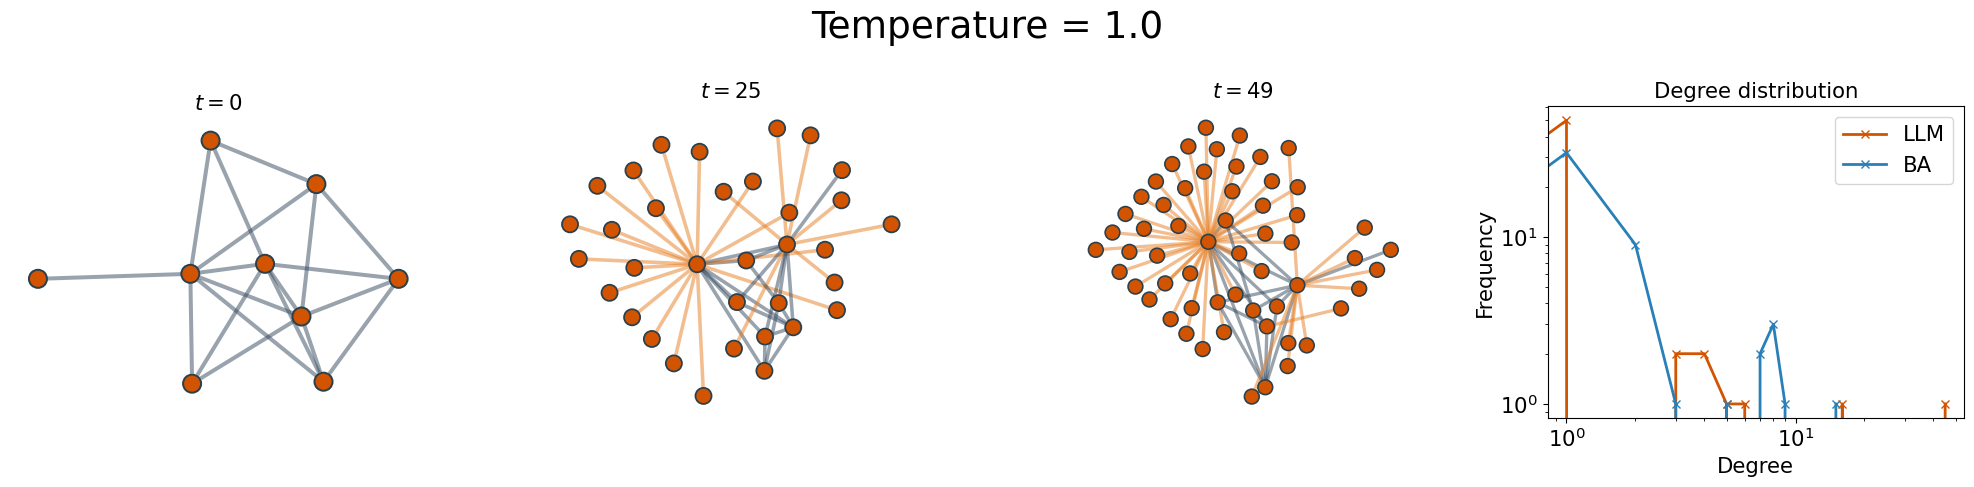

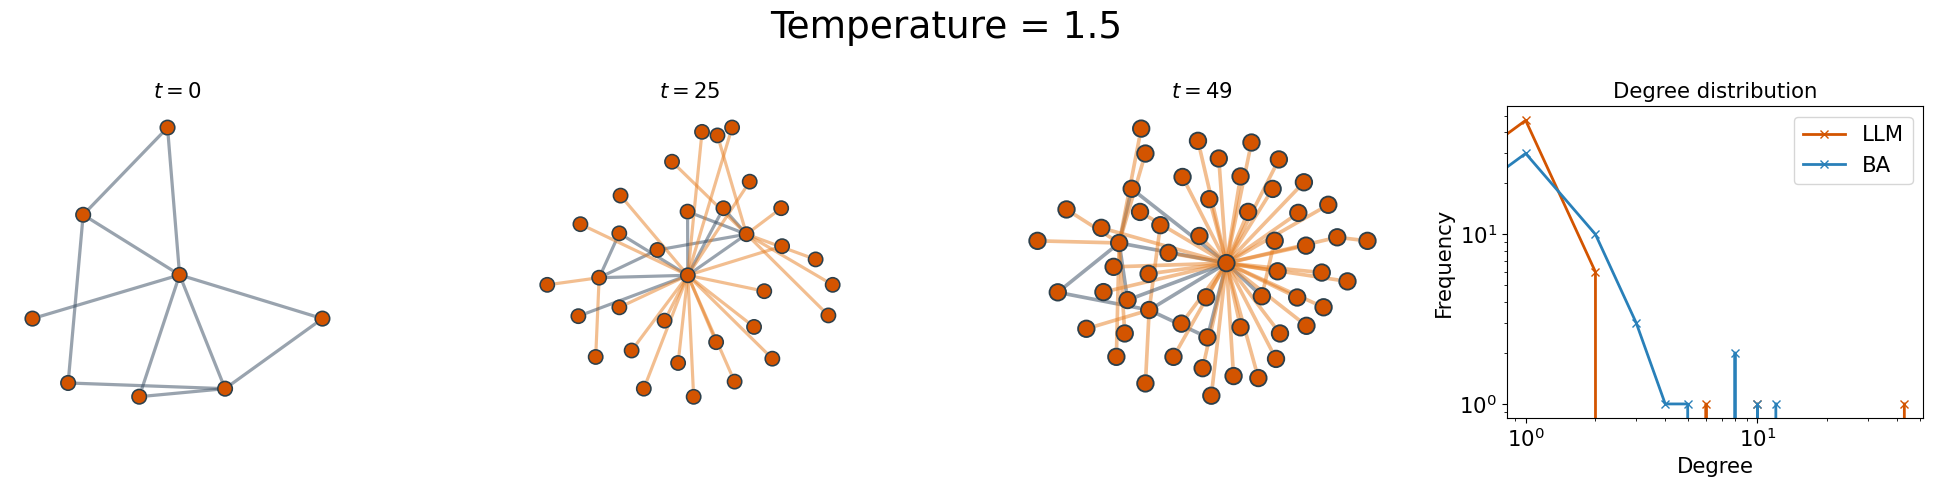

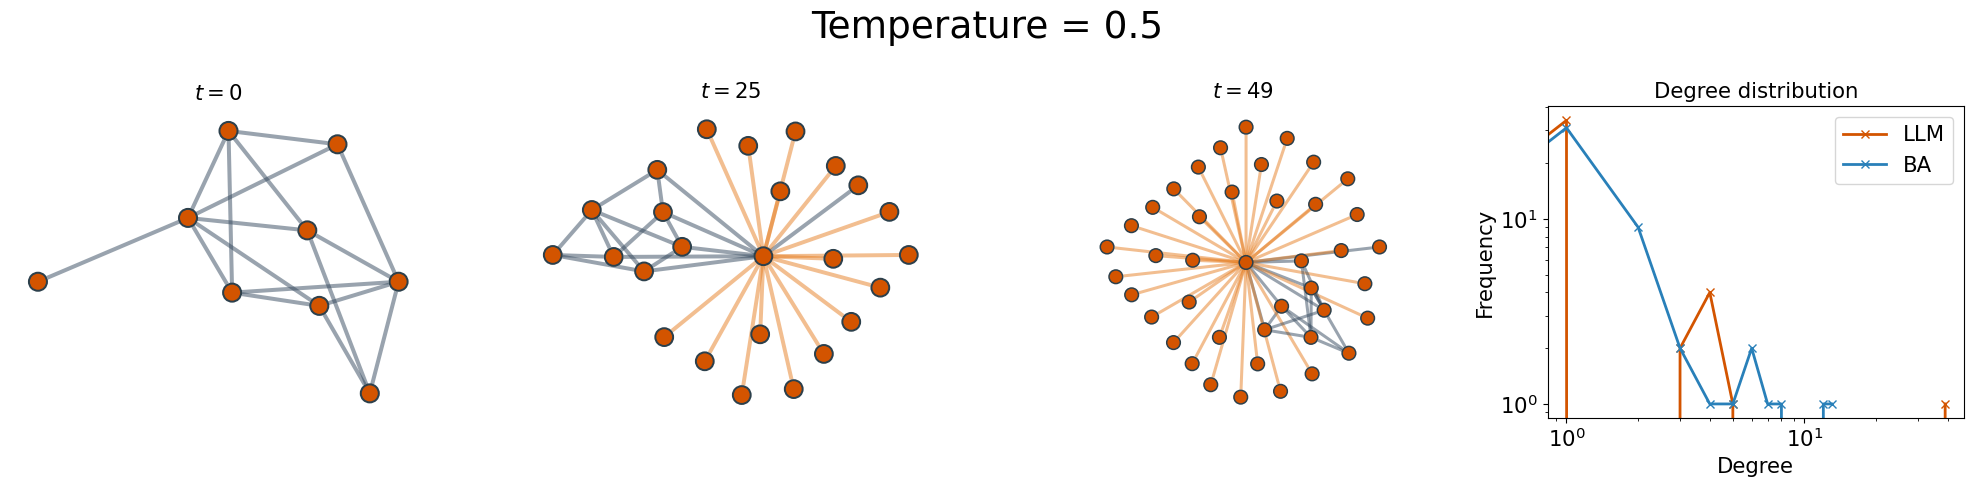

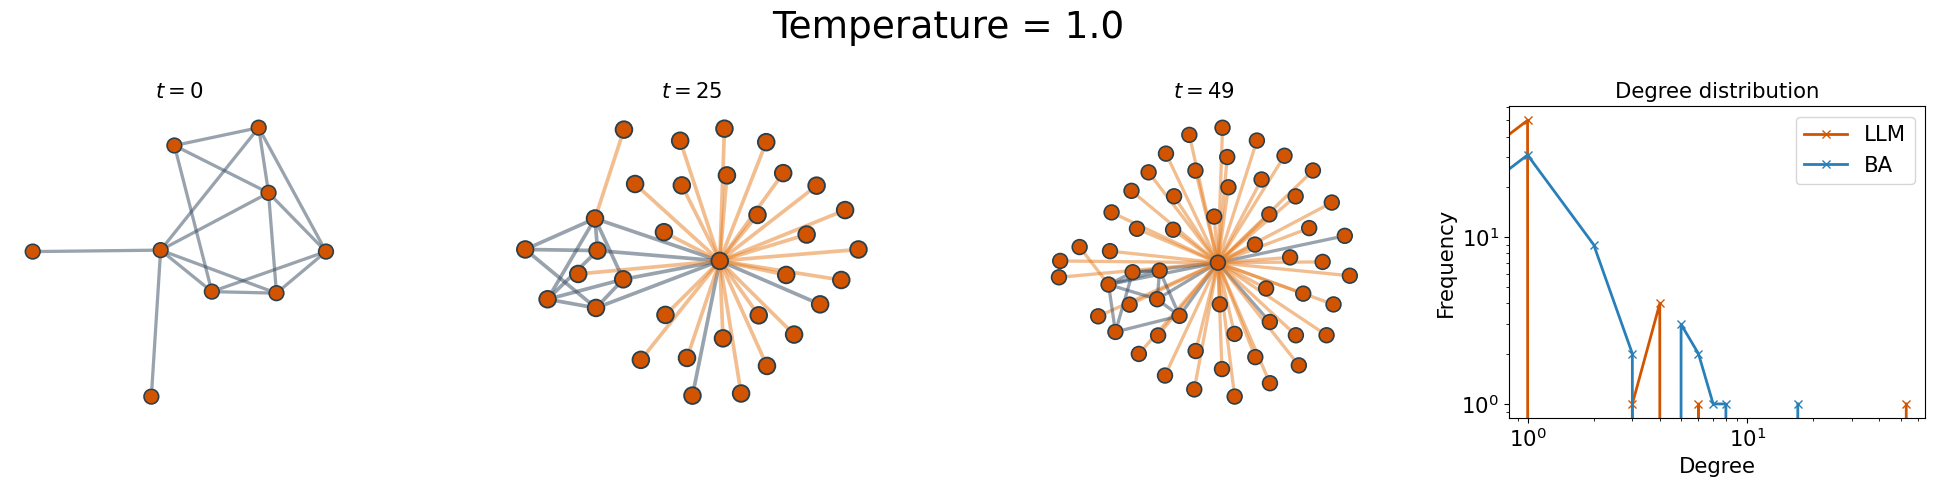

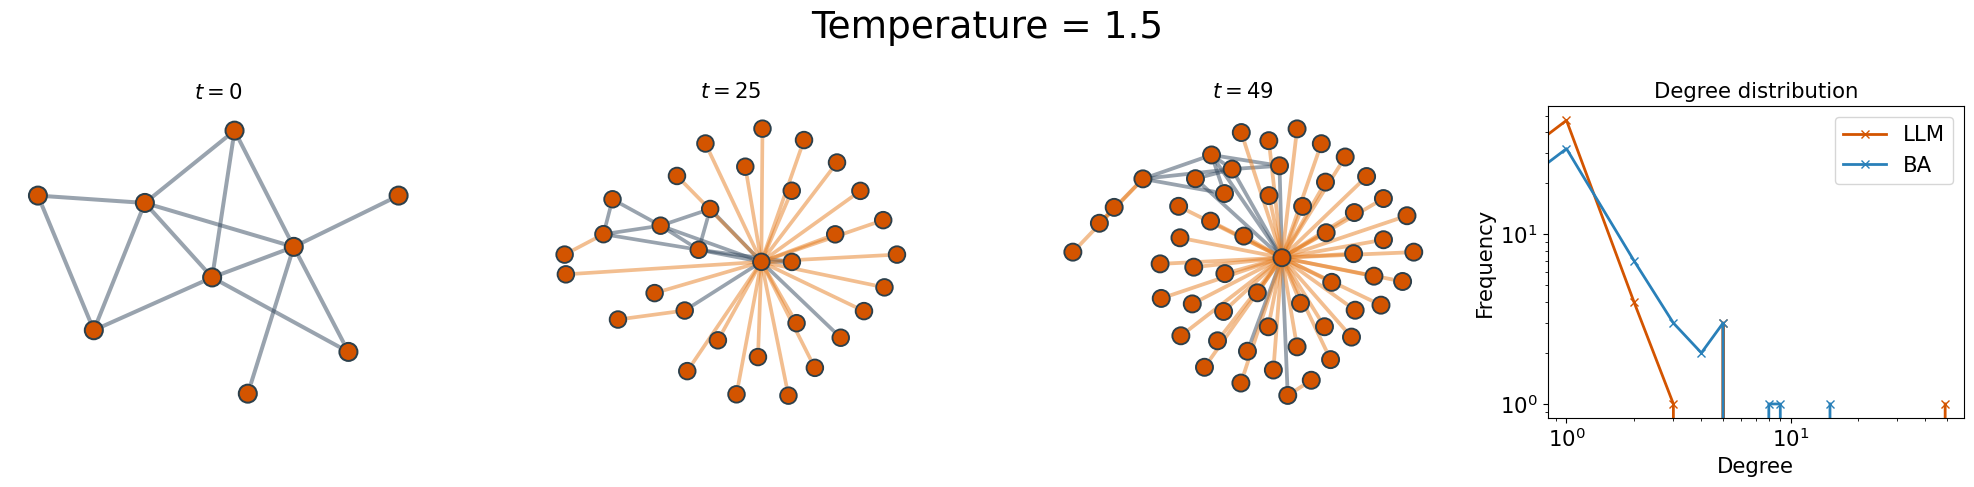

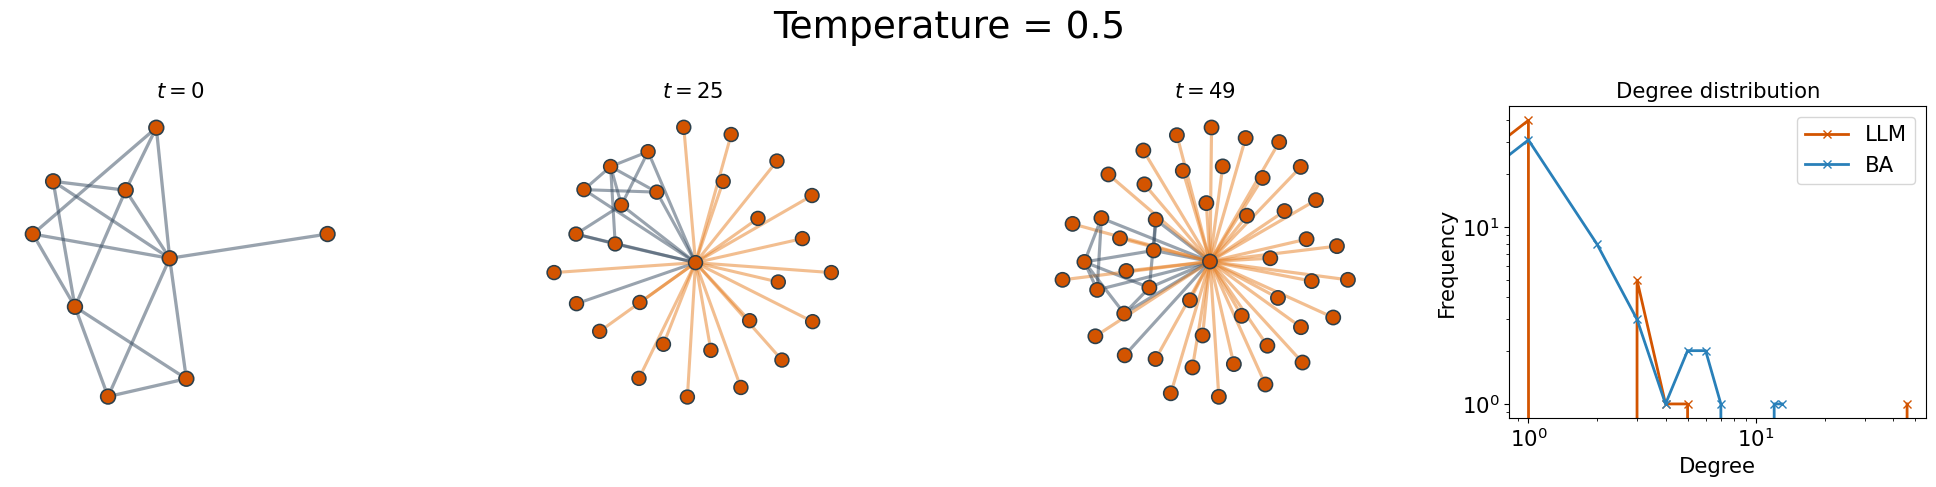

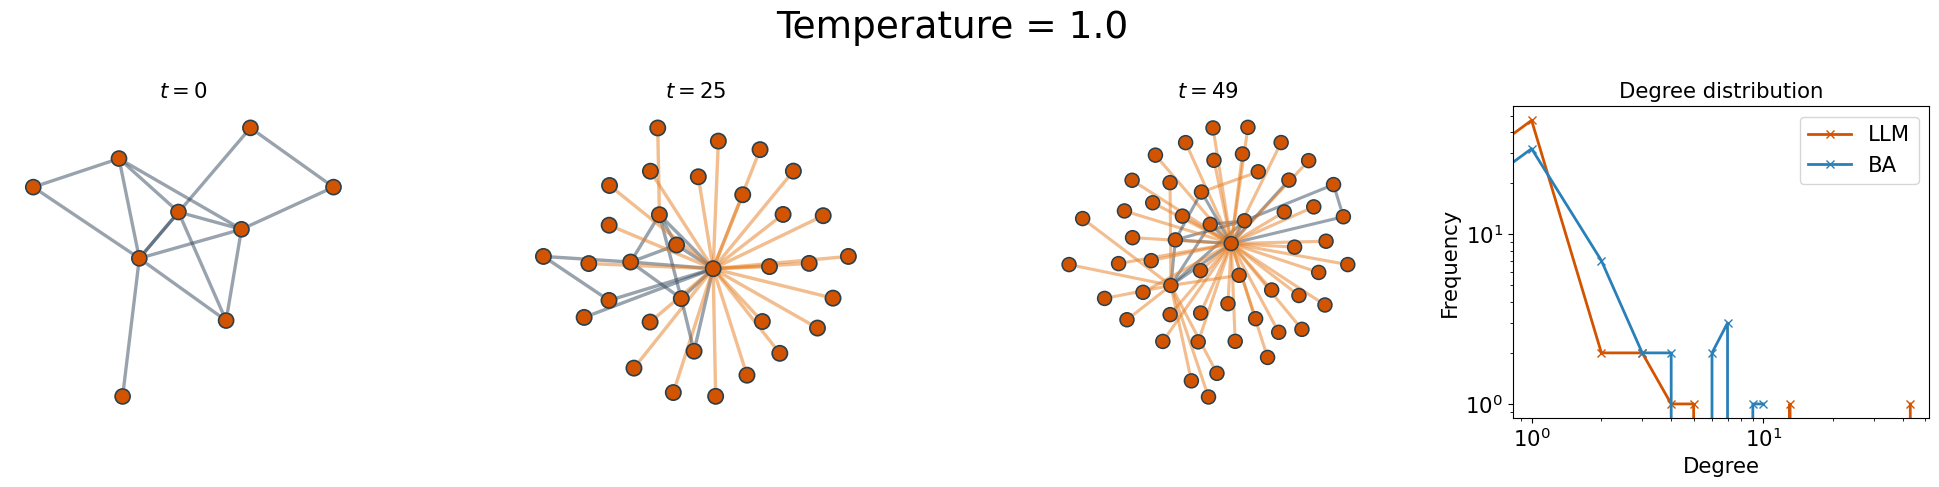

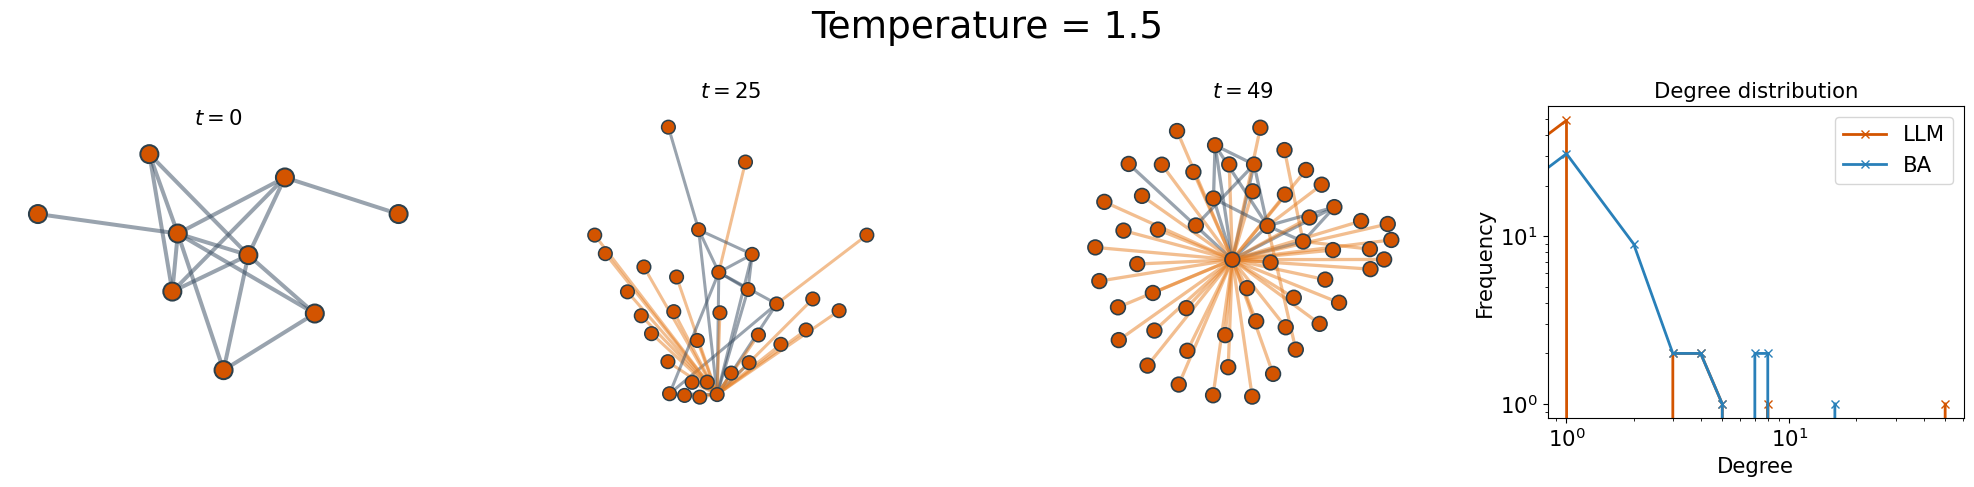

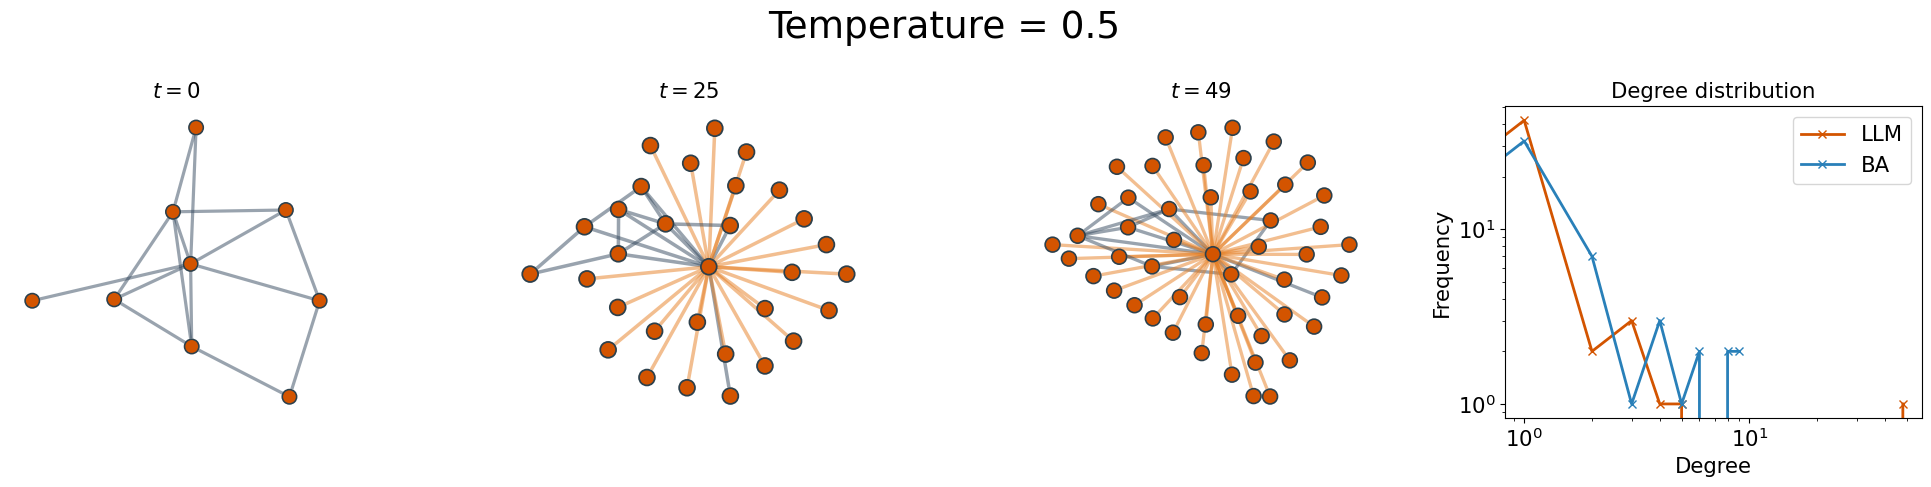

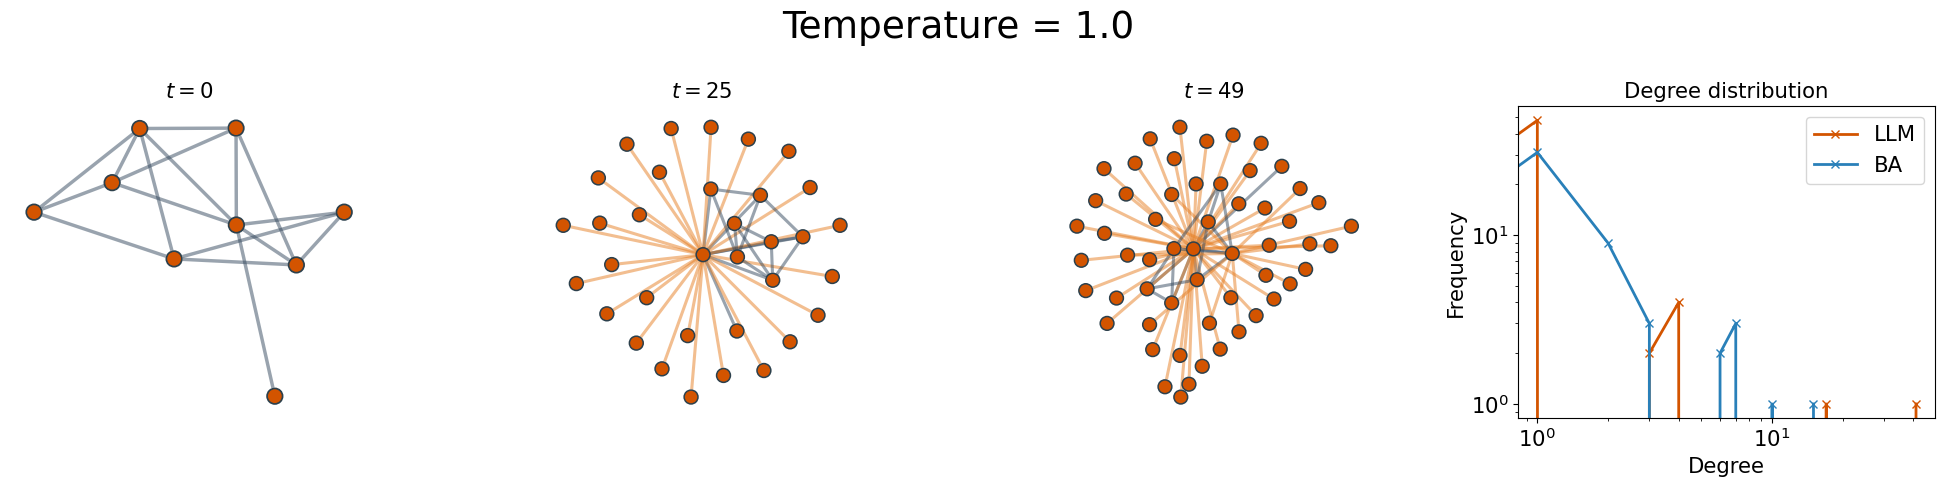

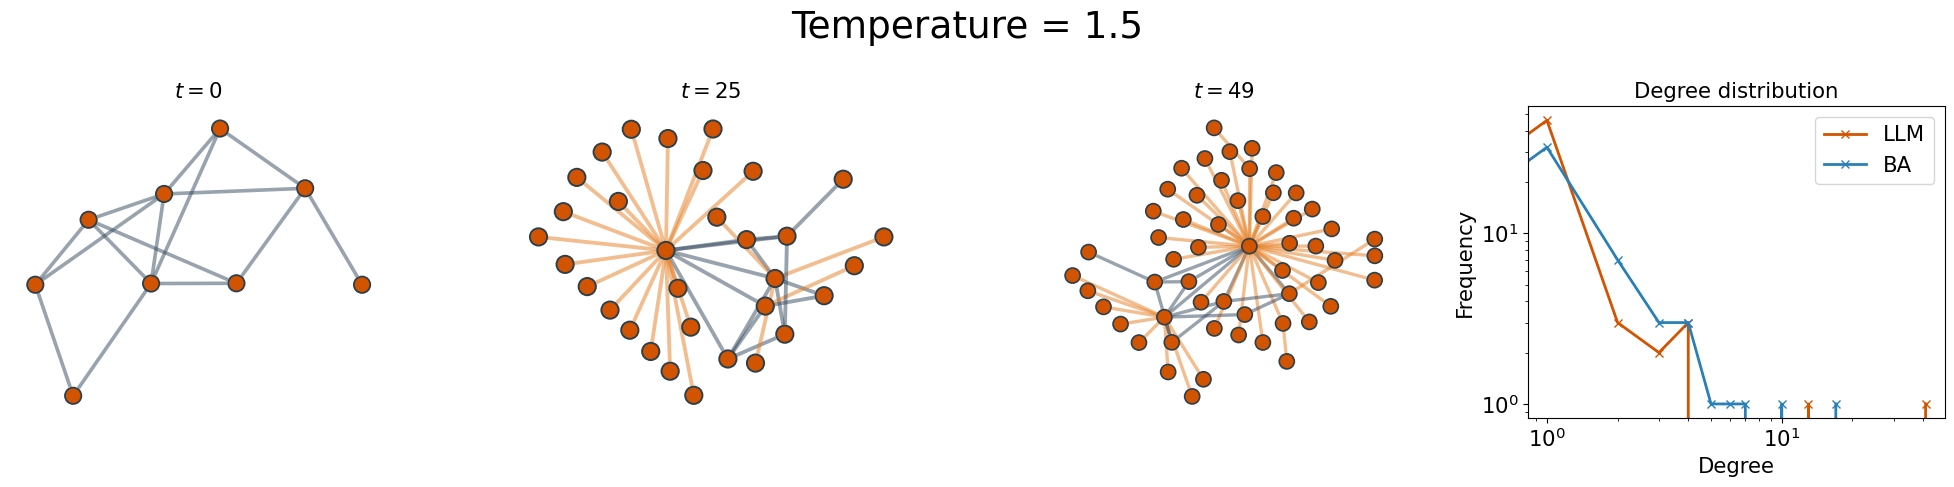

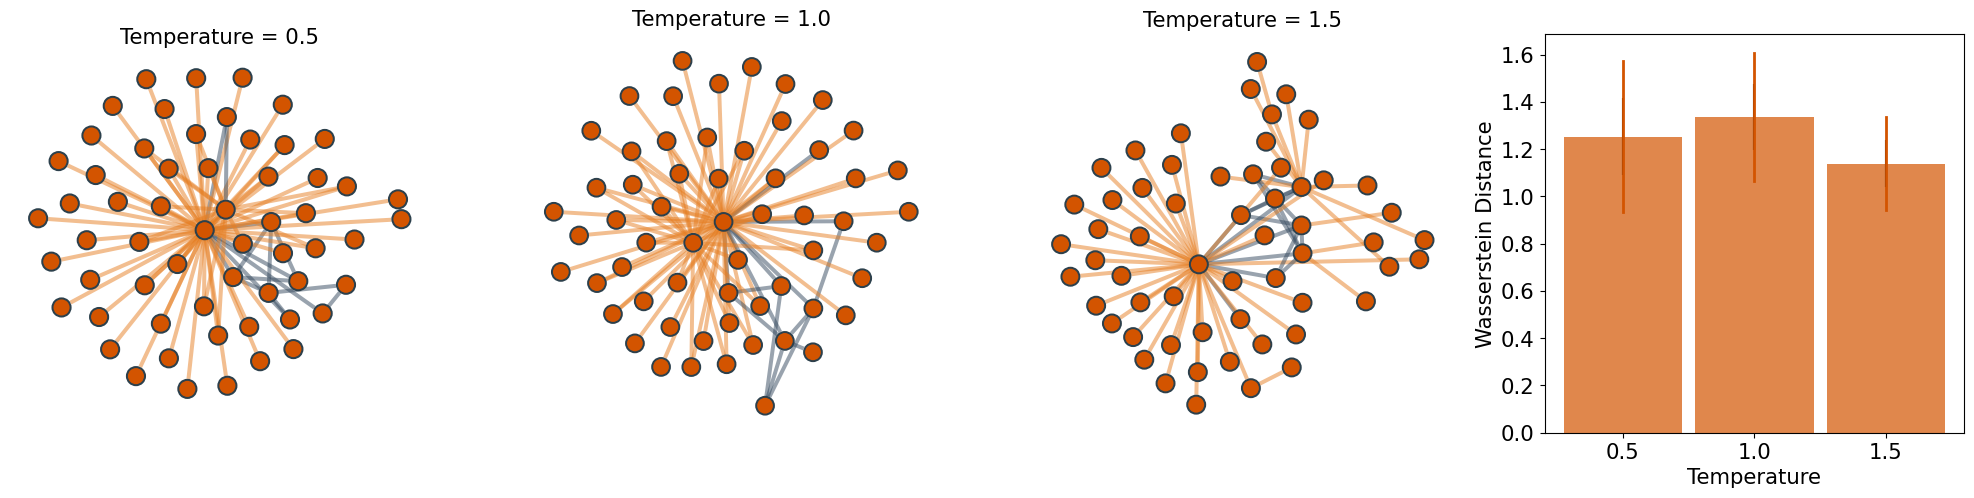

In [2]:
run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_1.jsonl', [0.5, 1.0, 1.5])
analyze_experiments('outputs/principle_1.jsonl')

In [ ]:
summarize_reasons('outputs/principle_1.jsonl')

: 